In [1]:

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import cProfile

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import SplineTransformer

import optuna
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer




from sklearn.decomposition import PCA, KernelPCA
from sklearn.cluster import FeatureAgglomeration
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC

import cv2 as cv2
from skimage.color import rgb2gray
from skimage.feature import hog, graycomatrix, graycoprops
from skimage.filters import gabor_kernel, gabor
from skimage import img_as_float32
from skimage.transform import resize

from joblib import Parallel, delayed


In [2]:
train = pd.read_csv('mnist_train.csv')
test  = pd.read_csv('mnist_test.csv')
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 785 entries, label to 28x28
dtypes: int64(785)
memory usage: 359.3 MB


# Preprocessing

In [3]:
encoder = OneHotEncoder()

train_target = train['label']
test_target = test['label']

train_values = train.drop('label', axis=1)
test_values = test.drop('label', axis=1)

train_values = train_values.values.reshape(-1, 28, 28) 
test_values = test_values.values.reshape(-1, 28, 28)

train_target_encoded = encoder.fit_transform(train_target.values.reshape(-1, 1)).toarray()
test_target_encoded = encoder.transform(test_target.values.reshape(-1, 1)).toarray()

print("Shape of train_values:", train_values.shape)
print("Shape of train_target_encoded:", train_target_encoded.shape)

print("Shape of test_values:", test_values.shape)
print("Shape of test_target_encoded:", test_target_encoded.shape)

Shape of train_values: (60000, 28, 28)
Shape of train_target_encoded: (60000, 10)
Shape of test_values: (10000, 28, 28)
Shape of test_target_encoded: (10000, 10)


In [4]:
X_train = train_values
X_train = train_values.astype(np.uint8)

y_train_ENC = train_target_encoded
y_train = np.argmax(y_train_ENC, axis=1)

X_test = test_values
X_test = test_values.astype(np.uint8)

y_test_ENC = test_target_encoded
y_test = np.argmax(y_test_ENC, axis=1)

In [5]:
# Sprawdzenie i konwersja typu danych
if X_train.dtype != np.uint8:
    X_train = X_train.astype(np.uint8)
if X_test.dtype != np.uint8:
    X_test = X_test.astype(np.uint8)

# Sprawdzenie i ewentualna korekta kształtu danych
if X_train.shape[1:] != (28, 28):
    X_train = X_train.reshape(-1, 28, 28)
if X_test.shape[1:] != (28, 28):
    X_test = X_test.reshape(-1, 28, 28)

# Wyrównywanie histogramu
for i in range(X_train.shape[0]):
    X_train[i] = cv2.equalizeHist(X_train[i])

for i in range(X_test.shape[0]):
    X_test[i] = cv2.equalizeHist(X_test[i])

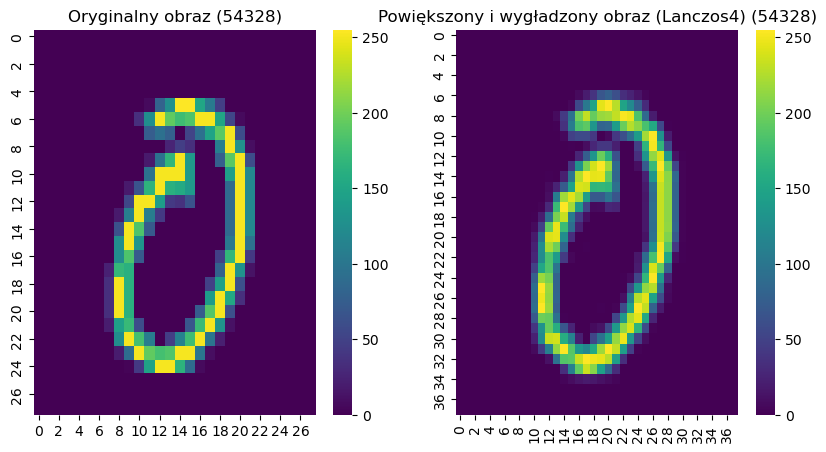

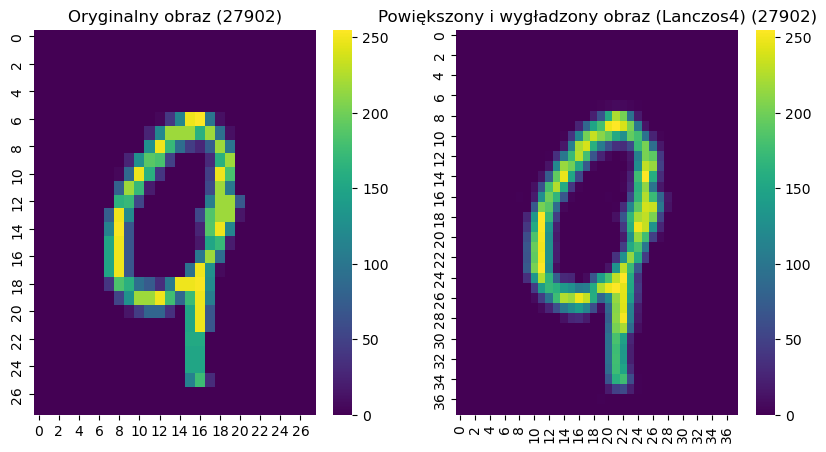

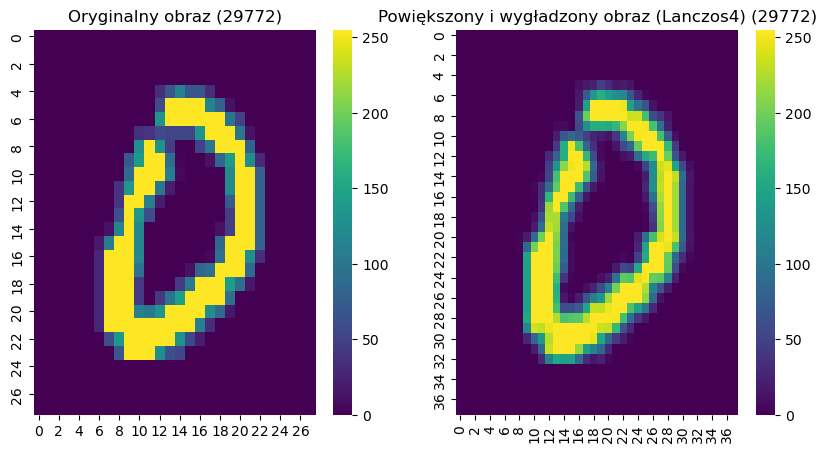

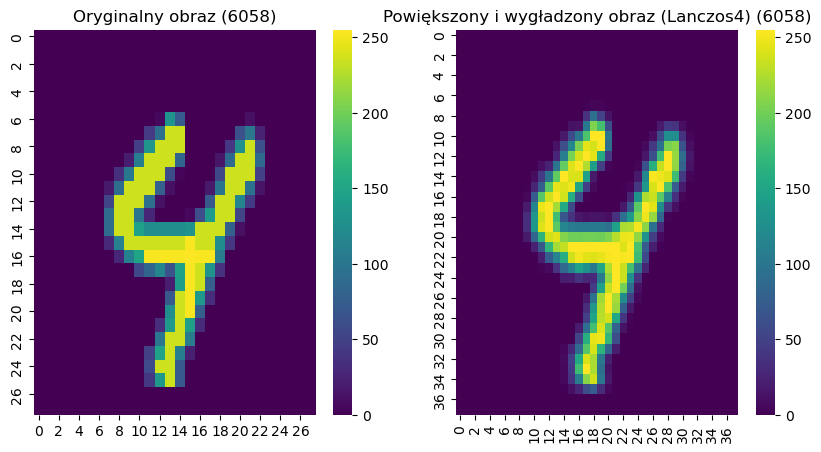

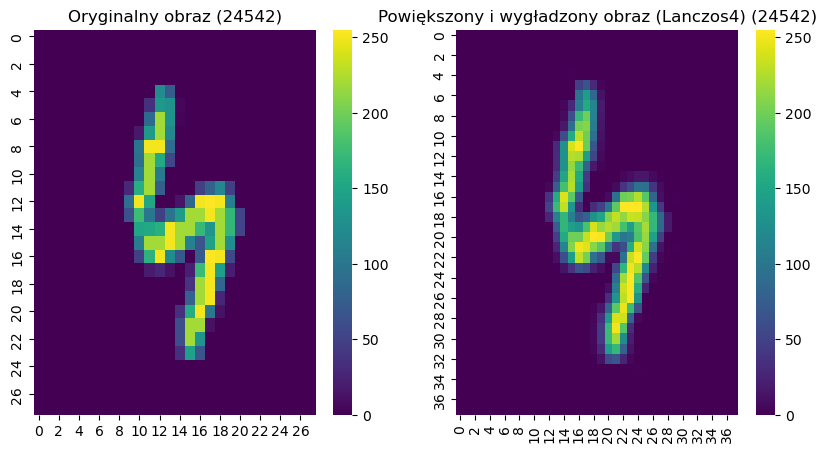

In [6]:
def enlarge_and_smooth(image, new_size):
    """Powiększa obraz za pomocą interpolacji bicubic."""
    enlarged_image = cv2.resize(image, new_size, interpolation=cv2.INTER_CUBIC)
    return enlarged_image

# Sztuczne zwiększenie rozmiaru obrazu 
sample_indices = np.random.choice(X_train.shape[0], 5, replace=False)

# Dla każdego wybranego obrazu
for idx in sample_indices:
    # Oryginalny obraz
    original_image = X_train[idx]

    # Powiększony i wygładzony obraz
    enlarged_smoothed_image = enlarge_and_smooth(original_image, new_size=(38, 38))  # Przykładowy nowy rozmiar

    # Wyświetl oryginalny i przekształcony obraz obok siebie
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    
    sns.heatmap(original_image, cmap="viridis", ax=axes[0])
    axes[0].set_title(f'Oryginalny obraz ({idx})')

    sns.heatmap(enlarged_smoothed_image, cmap="viridis", ax=axes[1])
    axes[1].set_title(f'Powiększony i wygładzony obraz (Lanczos4) ({idx})')

    #plt.show()

In [7]:
# # Baseline accuracy without transformations
# X_train_base, X_val_base, y_train_base, y_val_base = train_test_split(X_train, y_train, test_size=0.2, random_state=69)

# qda_base = QDA()
# qda_base.fit(X_train_base.reshape(X_train_base.shape[0], -1), y_train_base)  # Flatten images for QDA
# y_pred_qda_base = qda_base.predict(X_val_base.reshape(X_val_base.shape[0], -1))
# accuracy_qda_base = accuracy_score(y_val_base, y_pred_qda_base)

# svm_base = SVC()
# svm_base.fit(X_train_base.reshape(X_train_base.shape[0], -1), y_train_base)  # Flatten images for SVM
# y_pred_svm_base = svm_base.predict(X_val_base.reshape(X_val_base.shape[0], -1))
# accuracy_svm_base = accuracy_score(y_val_base, y_pred_svm_base)

# print("Baseline QDA accuracy:", accuracy_qda_base)
# print("Baseline SVM accuracy:", accuracy_svm_base)

#### Baseline QDA accuracy: 0.5525
#### Baseline SVM accuracy: 0.9793

## Deklaracja funkcji filtru Gabora, oraz H.O.G 

In [8]:

def calculate_hog_parallel(images, orientations=None, pixels_per_cell=None, cells_per_block=None, n_jobs=-1):
    """Oblicza deskryptory HOG dla obrazu."""
    
     # Ustawienie wartości domyślnych, jeśli parametry nie są podane
    if orientations is None:
        orientations = 9
    if pixels_per_cell is None:
        pixels_per_cell = (8, 8)
    if cells_per_block is None:
        cells_per_block = (2, 2)
    
    def calculate_hog(image, orientations=orientations, pixels_per_cell=pixels_per_cell, cells_per_block=cells_per_block):
        
        image = img_as_float32(image)

        fd = hog(image, orientations=orientations, pixels_per_cell=pixels_per_cell,
                cells_per_block=cells_per_block, visualize=False, channel_axis=None)

        return fd
    
    return Parallel(n_jobs=n_jobs)(delayed(calculate_hog)(image, orientations, pixels_per_cell, cells_per_block) for image in images)


def apply_gabor_filters_parallel(images, thetas=None, sigmas=None, frequencies=None, n_jobs=-1):
    """
    Stosuje filtry Gabora do wielu obrazów równolegle.

    Argumenty:
        images: Lista obrazów wejściowych (tablice NumPy).
        thetas: (Opcjonalnie) Lista kątów orientacji filtrów Gabora (w radianach). Jeśli None, używane są wartości domyślne.
        sigmas: (Opcjonalnie) Lista odchyleń standardowych filtrów Gabora. Jeśli None, używane są wartości domyślne.
        frequencies: (Opcjonalnie) Lista częstotliwości przestrzennych filtrów Gabora. Jeśli None, używane są wartości domyślne.
        n_jobs: Liczba rdzeni procesora do wykorzystania podczas zrównoleglania. -1 oznacza użycie wszystkich dostępnych rdzeni.

    Zwraca:
        Listę tablic NumPy zawierających obrazy przefiltrowane filtrami Gabora, o typie danych float32.
    """

    # Ustawienie wartości domyślnych, jeśli parametry nie są podane
    if thetas is None:
        thetas = [0, np.pi/4, np.pi/2, 3*np.pi/4]
    if sigmas is None:
        sigmas = [1, 3]
    if frequencies is None:
        frequencies = [0.05, 0.25]

    def apply_gabor_filters_single(image):
        image = img_as_float32(image)
        filtered_images = [gabor(image, frequency, theta=theta, sigma_x=sigma, sigma_y=sigma)[0]
                           for theta in thetas for sigma in sigmas for frequency in frequencies]
        return np.array(filtered_images, dtype=np.float32)

    return Parallel(n_jobs=n_jobs)(delayed(apply_gabor_filters_single)(image) for image in images)


def extract_features_HOG_Gabor(X, hog_orientations=None, hog_pixels_per_cell=None, hog_cells_per_block=None, 
                              gabor_thetas=None, gabor_sigmas=None, gabor_frequencies=None):
    """Generator zwracający cechy HOG i Gabora dla obrazów."""

    hog_features_list = calculate_hog_parallel(X, orientations=hog_orientations, pixels_per_cell=hog_pixels_per_cell, cells_per_block=hog_cells_per_block)
    gabor_features_list = apply_gabor_filters_parallel(X, thetas=gabor_thetas, sigmas=gabor_sigmas, frequencies=gabor_frequencies)

    for hog_features, gabor_features in zip(hog_features_list, gabor_features_list):
        
        gabor_features_flattened = np.array([img.flatten() for img in gabor_features])

        # Dopasowujemy kształt hog_features do gabor_features_flattened
        hog_features_reshaped = np.repeat(hog_features.reshape(1, -1), gabor_features_flattened.shape[0], axis=0)

        # Łączymy cechy HOG i Gabora w poziomie
        concatenated_features = np.hstack((hog_features_reshaped, gabor_features_flattened))

        concatenated_features = concatenated_features.flatten()

        yield concatenated_features

## Testowanie modelu dla HOG i filtrów Gabora i porównaie wydajności z zastosowaniem redukcji wymiarów. 

In [9]:
# def train_and_evaluate_models(X_train, y_train, use_pca=True):
#     """
#     Trenuje i ocenia modele QDA i SVC, opcjonalnie z redukcją wymiarów PCA.

#     Argumenty:
#         X_train: Dane treningowe.
#         y_train: Etykiety treningowe.
#         use_pca: Flaga wskazująca, czy używać PCA (domyślnie True).
#     """

#     # Ekstrakcja cech HOG i Gabor za pomocą generatora
#     X_train_features = np.array(list(extract_features_HOG_Gabor(X_train)))

#     # Podział na zbiór treningowy i walidacyjny
#     X_train, X_val, y_train, y_val = train_test_split(X_train_features, y_train, test_size=0.2, random_state=69)

#     # Redukcja wymiarów (opcjonalnie)
#     if use_pca:
#         pca_dim = PCA(n_components=50)
#         X_train = pca_dim.fit_transform(X_train)
#         X_val = pca_dim.transform(X_val)

#     # Tworzenie i trenowanie modelu QDA
#     qda = QDA()
#     qda.fit(X_train, y_train)

#     # Tworzenie i trenowanie modelu SVC
#     svc = SVC(kernel='rbf')
#     svc.fit(X_train, y_train)

#     # Ocena modelu
#     y_pred_qda = qda.predict(X_val)
#     accuracy_qda = accuracy_score(y_val, y_pred_qda)

#     y_pred_svc = svc.predict(X_val)
#     accuracy_svc = accuracy_score(y_val, y_pred_svc)

#     print("Dokładność QDA HOG i Gabor", "po PCA:" if use_pca else ":", accuracy_qda)
#     print("Dokładność SVC HOG i Gabor", "po PCA:" if use_pca else ":", accuracy_svc)

# # Test z PCA
# train_and_evaluate_models(X_train, y_train, use_pca=True)
#train_and_evaluate_models(X_train, y_train, use_pca=False)
#cProfile.run('train_and_evaluate_models(X_train, y_train, use_pca=True)') 

#### Dokładność QDA HOG i Gabor       : 0.5734
#### Dokładność SVC HOG i Gabor       : 0.987

#### Dokładność QDA HOG i Gabor po PCA: 0.9701
#### Dokładność SVC HOG i Gabor po PCA: 0.9869

#### Czas obliczeń dla PCA 3min vs 30min bez PCA

### Szybkie sprawdzenie czy PCA poprawi wyniki

### OPTUNA dla HOG, Gabor, PCA

In [10]:
# import warnings
# warnings.filterwarnings("ignore", module="optuna")


# def objective(trial, X_train, y_train):
#     """
#     Funkcja celu dla optymalizacji Optuna. 
#     Przyjmuje próbę (trial), dane treningowe (X_train) i etykiety (y_train).
#     Zwraca dokładność QDA i SVM na danych walidacyjnych po zastosowaniu sekwencji transformacji.
#     """

#     # Parametry HOG
#     orientations      = trial.suggest_int("hog_orientations", 2, 16)
#     pixels_per_cell   = trial.suggest_categorical("hog_pixels_per_cell", [str((2, 2)), str((2, 3)), str((3, 2)), str((3, 3)), str((4, 4)), str((5, 5)),str((6, 6)), str((7, 7))])
#     cells_per_block   = trial.suggest_categorical("hog_cells_per_block", [str((1, 1)), str((2, 2)), str((3, 3)), str((4, 4))])

#     # Parametry filtrów Gabora
#     gabor_thetas      = trial.suggest_categorical("gabor_thetas", ([0],  [np.pi / 14],  [np.pi / 12], [0, np.pi / 14 ], [0, np.pi / 12 ] ))
#     gabor_sigmas      = trial.suggest_categorical("gabor_sigmas", ([0.33], [0.66], [1], [0.33 , 1.25], [0.66, 2.35], [1, 3]))
#     gabor_frequencies = trial.suggest_categorical("gabor_frequencies", ([0.025], [0.05], [0.125], [0.025, 0.125], [0.05, 0.175], [0.05, 0.25]))
        
#     #PCA
#     PCA_n_components  =  trial.suggest_int("PCA_Components", 4, 228)
#     kernel = trial.suggest_categorical("kernel_pca_kernel", ['linear', 'poly', 'rbf', 'sigmoid', 'cosine'])
#     gamma = None
#     if kernel in ['poly', 'rbf']:
#         gamma = trial.suggest_loguniform("kernel_pca_gamma", 0.001, 1)
        
#     # Powiększanie i wygładzanie
#     # X_train_split = np.array([enlarge_and_smooth(img, new_size) for img in X_train])
#     # X_val = np.array([enlarge_and_smooth(img, new_size) for img in X_val])
    
#     # Ekstrakcja cech HOG i Gabor
#     X_train_features = np.array(list(extract_features_HOG_Gabor(
#         X_train, 
#         hog_orientations=orientations, 
#         hog_pixels_per_cell=eval(pixels_per_cell), # Konwersja stringa na krotkę
#         hog_cells_per_block=eval(cells_per_block),  # Konwersja stringa na krotkę
#         gabor_thetas=gabor_thetas, 
#         gabor_sigmas=gabor_sigmas, 
#         gabor_frequencies=gabor_frequencies
#     )))

#     # Podział na zbiór treningowy i walidacyjny
#     X_train_filters, X_val_filters, y_train_filters, y_val_filters = train_test_split(X_train_features, y_train, test_size=0.2, random_state=69)
    
    
#     # Kernel PCA
#     kpca = KernelPCA(n_components=PCA_n_components, kernel=kernel, gamma=gamma)
#     X_train_reduced = kpca.fit_transform(X_train_filters)
#     X_val_reduced = kpca.transform(X_val_filters)
                
#     # SVC
#     svc = SVC(kernel='rbf')
#     svc.fit(X_train_reduced, y_train_filters)
#     y_pred_svm = svc.predict(X_val_reduced)
#     accuracy_svm = accuracy_score(y_val_filters, y_pred_svm)

#     return accuracy_svm

# # Optymalizacji
                            
# study = optuna.create_study(directions=["maximize"], sampler=optuna.samplers.CmaEsSampler() ) 
# study.optimize(lambda trial: objective(trial, X_train, y_train), n_trials=100, n_jobs=1)


# print("Best parameters:", study.best_params)
# print("Best QDA accuracy:", study.best_trial.values[0]) 
# print("Best SVM accuracy:", study.best_trial.values[1]) 

# # [I 2024-09-17 05:43:37,964] Trial 13 finished with value: 0.99133 and parameters: {'hog_orientations': 16, 'hog_pixels_per_cell': '(4, 4)', 'hog_cells_per_block': '(3, 3)', 'gabor_thetas': [0.2243994752564138], 'gabor_sigmas': [0.66, 2.35], 'gabor_frequencies': [0.025], 'PCA_Components': 209, 'kernel_pca_kernel': 'cosine'}. Best is trial 13 with value: 0.9913333333333333.
# # [I 2024-09-17 08:45:58,345] Trial 19 finished with value: 0.99175 and parameters: {'hog_orientations': 6, 'hog_pixels_per_cell': '(2, 3)', 'hog_cells_per_block': '(2, 2)', 'gabor_thetas': [0.2617993877991494], 'gabor_sigmas': [1], 'gabor_frequencies': [0.025], 'PCA_Components': 132, 'kernel_pca_kernel': 'sigmoid'}. Best is trial 19 with value: 0.99175.
# # [I 2024-09-17 10:45:29,605] Trial 23 finished with value: 0.99225 and parameters: {'hog_orientations': 6, 'hog_pixels_per_cell': '(3, 3)', 'hog_cells_per_block': '(2, 2)', 'gabor_thetas': [0], 'gabor_sigmas': [1], 'gabor_frequencies': [0.05, 0.25], 'PCA_Components': 150, 'kernel_pca_kernel': 'cosine'}. Best is trial 23 with value: 0.99225.
# # [I 2024-09-17 13:24:59,082] Trial 28 finished with value: 0.99108 and parameters: {'hog_orientations': 9, 'hog_pixels_per_cell': '(3, 2)', 'hog_cells_per_block': '(1, 1)', 'gabor_thetas': [0, 0.2617993877991494], 'gabor_sigmas': [1], 'gabor_frequencies': [0.05, 0.25], 'PCA_Components': 190, 'kernel_pca_kernel': 'sigmoid'}. Best is trial 23 with value: 0.99225.
# # [I 2024-09-17 13:54:44,248] Trial 29 finished with value: 0.9915 and parameters: {'hog_orientations': 7, 'hog_pixels_per_cell': '(4, 4)', 'hog_cells_per_block': '(4, 4)', 'gabor_thetas': [0.2617993877991494], 'gabor_sigmas': [0.66, 2.35], 'gabor_frequencies': [0.05], 'PCA_Components': 164, 'kernel_pca_kernel': 'cosine'}. Best is trial 23 with value: 0.99225.
# # [I 2024-09-17 18:02:03,444] Trial 37 finished with value: 0.99066 and parameters: {'hog_orientations': 9, 'hog_pixels_per_cell': '(3, 2)', 'hog_cells_per_block': '(4, 4)', 'gabor_thetas': [0], 'gabor_sigmas': [0.66, 2.35], 'gabor_frequencies': [0.05, 0.175], 'PCA_Components': 169, 'kernel_pca_kernel': 'rbf', 'kernel_pca_gamma': 0.0032186977490984547}. Best is trial 23 with value: 0.99225.
# # [I 2024-09-17 19:02:58,946] Trial 39 finished with value: 0.9915 and parameters: {'hog_orientations': 6, 'hog_pixels_per_cell': '(4, 4)', 'hog_cells_per_block': '(4, 4)', 'gabor_thetas': [0, 0.2243994752564138], 'gabor_sigmas': [1, 3], 'gabor_frequencies': [0.125], 'PCA_Components': 148, 'kernel_pca_kernel': 'linear'}. Best is trial 23 with value: 0.99225.


In [11]:
# X_train_features = np.array(list(extract_features_HOG_Gabor(
#         X_train, 
#         hog_orientations=6, 
#         hog_pixels_per_cell=eval('(3, 3)'), 
#         hog_cells_per_block=eval('(2, 2)'),  
#         gabor_thetas=[0], 
#         gabor_sigmas=[1], 
#         gabor_frequencies=[0.05, 0.25]
#     )))


# kpca = KernelPCA(n_components=150, kernel='cosine')

# X_train_filters, X_val_filters, y_train_filters, y_val_filters = train_test_split(X_train_features, y_train_ENC, test_size=0.2, random_state=69)

# X_train_reduced = kpca.fit_transform(X_train_filters)
# X_val_reduced = kpca.transform(X_val_filters)


# np.save('X_train_reduced.npy', X_train_reduced)
# np.save('X_val_reduced.npy', X_val_reduced)
# np.save('y_train_filters.npy', y_train_filters)
# np.save('y_val_filters.npy', y_val_filters)


In [16]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, LayerNormalization , BatchNormalization, PReLU , Input, ActivityRegularization, GlobalAveragePooling1D, SeparableConv1D 
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Lion
from tensorflow.keras.callbacks import EarlyStopping
import gc



X_train_reduced = np.load('X_train_reduced.npy')
X_val_reduced = np.load('X_val_reduced.npy')
y_train_filters = np.load('y_train_filters.npy')
y_val_filters = np.load('y_val_filters.npy')

X_train_reduced = X_train_reduced.reshape(X_train_reduced.shape[0], X_train_reduced.shape[1], 1)
X_val_reduced = X_val_reduced.reshape(X_val_reduced.shape[0], X_val_reduced.shape[1], 1)

def calculate_max_pool_size(input_length, prev_pool_size, min_output_size=2):
    calculated_pool_size = input_length // prev_pool_size
    return max(min_output_size, calculated_pool_size)


def objective(trial):
    """Funkcja celu dla Optuny."""
    #os.environ['TF_NUM_INTRAOP_THREADS'] = '1' ## Czy Kers działa na pojedycznym wątku ????
    gc.collect()
    tf.keras.backend.clear_session()
    gc.collect()

    activation_functions = ['relu', 'elu', 'leaky_relu', 'tanh']
    activation = trial.suggest_categorical('activation', activation_functions)

    # Definiowanie modelu
    model = Sequential()
    model.add(Input(shape=(X_train_reduced.shape[1], 1)))

    # Pierwsza warstwa konwolucyjna
    model.add(Conv1D(filters=trial.suggest_int('conv1d_filters_1', 48, 450),
                     kernel_size=trial.suggest_int('kernel_size_1', 2, 16),
                     #activation=activation,
                     padding='same', 
                     #dilation_rate=trial.suggest_int('dilation_rate_1', 1, 4)
                     )
              )
    model.add(PReLU())
    model.add(LayerNormalization())
    model.add(ActivityRegularization(l1=trial.suggest_float('l1_1', 1e-6, 1e-1, log=True), 
                                     l2=trial.suggest_float('l2_1', 1e-6, 1e-1, log=True)
                                     )
              )
    pool_size_1 = trial.suggest_int('pool_size_1', 2, 10)
    model.add(MaxPooling1D(pool_size=pool_size_1))



    # Druga warstwa konwolucyjna
    input_length_2 = X_train_reduced.shape[1] // pool_size_1
    model.add(Conv1D(filters=trial.suggest_int('conv1d_filters_2', 24, 400),
                     kernel_size=trial.suggest_int('kernel_size_2', 2, 14),
                     padding='same',
                     #activation=activation,
                     #dilation_rate=trial.suggest_int('dilation_rate_2', 1, 4)
                     )
              )
    model.add(PReLU())
    model.add(LayerNormalization())
    model.add(ActivityRegularization(l1=trial.suggest_float('l1_2', 1e-6, 1e-1, log=True), 
                                     l2=trial.suggest_float('l2_2', 1e-6, 1e-1, log=True)
                                     )
              )
    pool_size_2 = trial.suggest_int('pool_size_2', 2, input_length_2 // 2)
    #pool_size_2 = trial.suggest_int('pool_size_2', 2, 10)
    model.add(MaxPooling1D(pool_size=pool_size_2))



    # Trzecia warstwa konwolucyjna
    #input_length_3 = input_length_2 // pool_size_2
    model.add(Conv1D(filters=trial.suggest_int('conv1d_filters_3', 32, 300),
                     kernel_size=trial.suggest_int('kernel_size_3', 2, 12),
                     padding='same',
                     )
              )
    model.add(PReLU())
    model.add(LayerNormalization())
    model.add(Dropout(rate=trial.suggest_float('dropout_rate_3', 0.01, 0.5)
                      )
              )
    #pool_size_3 = trial.suggest_int('pool_size_3', 2, max(2, input_length_3 // 2))
    #pool_size_3 = trial.suggest_int('pool_size_3', 2, 8)
    #model.add(MaxPooling1D(pool_size=pool_size_3))

    # Warstwy Dense
    model.add(GlobalAveragePooling1D())
    
    model.add(Dense(units=trial.suggest_int('dense_units_1', 40, 300), activation=activation))
    model.add(Dropout(rate=trial.suggest_float('dropout_rate_4', 0.01, 0.75)))
    
    model.add(Dense(units=trial.suggest_int('dense_units_2', 20, 200), activation=activation))
    model.add(Dropout(rate=trial.suggest_float('dropout_rate_5', 0.01, 0.65)))
    
    model.add(Dense(10, activation='softmax'))

    # Optymalizator
    lr_initial = trial.suggest_float("lr_initial", 1e-5, 1e-1, log=True)
    decay_steps = trial.suggest_int("decay_steps", 10, 150)
    decay_rate = trial.suggest_float("decay_rate", 0.01, 0.99)
    lr_schedule = ExponentialDecay(initial_learning_rate=lr_initial,
                                  decay_steps=decay_steps,
                                  decay_rate=decay_rate)

    optimizer_name = trial.suggest_categorical('optimizer', ['Lion'])
    optimizer_class = getattr(tf.keras.optimizers, optimizer_name)
    optimizer = optimizer_class(learning_rate=lr_schedule)

    
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    # Early Stopping
    early_stopping = EarlyStopping(monitor='val_accuracy', patience=16, start_from_epoch=10, min_delta = 0.00005)

    # Trenowanie modelu
    model.fit(X_train_reduced, y_train_filters,
              epochs=trial.suggest_int('epochs', 40, 150),
              batch_size=trial.suggest_int('batch_size', 64, 1920),
              validation_data=(X_val_reduced, y_val_filters),
              verbose=0,
              callbacks=[early_stopping])

    # Ewaluacja modelu
    _, accuracy = model.evaluate(X_val_reduced, y_val_filters, verbose=0)

    del model
    return accuracy

study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler())
study.optimize(objective, n_trials=600, n_jobs=1, gc_after_trial=True) ## Czy keras działa na wszystkich wątkach, ale optuna na pojedynczym. 


# Najlepsze parametry i wynik
print("Najlepsze parametry:", study.best_params)
print("Najlepsza dokładność:", study.best_value)



[I 2024-10-03 22:29:18,431] A new study created in memory with name: no-name-5a5864bc-3881-441a-9fee-2df1dbd8201c
[I 2024-10-03 22:44:29,046] Trial 0 finished with value: 0.1067499965429306 and parameters: {'activation': 'relu', 'conv1d_filters_1': 435, 'kernel_size_1': 6, 'l1_1': 0.0009453064495870181, 'l2_1': 0.055186769733499105, 'pool_size_1': 6, 'conv1d_filters_2': 207, 'kernel_size_2': 4, 'l1_2': 0.023044939873551745, 'l2_2': 0.06364698850966621, 'pool_size_2': 7, 'conv1d_filters_3': 68, 'kernel_size_3': 10, 'dropout_rate_3': 0.22467502110188756, 'dense_units_1': 101, 'dropout_rate_4': 0.1225335617760363, 'dense_units_2': 58, 'dropout_rate_5': 0.40084573092898823, 'lr_initial': 0.00021797314714321967, 'decay_steps': 73, 'decay_rate': 0.9311245355022338, 'optimizer': 'Lion', 'epochs': 93, 'batch_size': 740}. Best is trial 0 with value: 0.1067499965429306.
[I 2024-10-03 22:52:06,493] Trial 1 finished with value: 0.12566666305065155 and parameters: {'activation': 'elu', 'conv1d_filt

## Deklracja funkcji dla Filtry kierunkowych, oraz Oriented FAST and rotated BRIEF

In [11]:
def apply_directional_filters(image, kernel_sizes=[3, 5, 7]):
    """Stosuje filtry kierunkowe do obrazu."""
    filtered_images = []
    for kernel_size in kernel_sizes:
        kernel_horizontal = cv2.getDerivKernels(1, 0, kernel_size, normalize=True)
        kernel_vertical = cv2.getDerivKernels(0, 1, kernel_size, normalize=True)
        filtered_horizontal = cv2.filter2D(image, cv2.CV_32F, kernel_horizontal[0])
        filtered_vertical = cv2.filter2D(image, cv2.CV_32F, kernel_vertical[0])
        filtered_images.append(filtered_horizontal.flatten())
        filtered_images.append(filtered_vertical.flatten())
        if kernel_size % 2 == 0 or kernel_size > 31:
            raise ValueError(f"Nieprawidłowy rozmiar jądra: {kernel_size}. Rozmiar jądra musi być nieparzysty i nie większy niż 31.")
    return np.array(filtered_images).squeeze()

def extract_orb_features(image, nfeatures=500):
    """Wyodrębnia cechy ORB z obrazu."""
    orb = cv2.ORB_create(nfeatures=nfeatures)  
    keypoints, descriptors = orb.detectAndCompute(image, None)
    if descriptors is None:
        return np.zeros(nfeatures * 32)  
    return descriptors.flatten()

In [ ]:
def extract_features_and_train(X_train, y_train, batch_size=2000):

    # Inicjalizacja pustych list na cechy
    all_features = []

    for i in range(0, len(X_train), batch_size):
        batch = X_train[i:i + batch_size]

        # Ekstrakcja cech dla partii danych
        batch_features = np.array([np.concatenate([
            apply_directional_filters(img).flatten(),
            extract_orb_features(img)
        ]) for img in batch])

        all_features.append(batch_features)

    # Połączenie cech z wszystkich partii
    X_train_features = np.vstack(all_features)

    # StratifiedKFold
    cv = StratifiedKFold(n_splits=8)
    for train_idx, val_idx in cv.split(X_train_features, y_train):
        X_train, X_val = X_train_features[train_idx], X_train_features[val_idx]
        y_train, y_val = y_train[train_idx], y_train[val_idx]

        # Redukcja wymiarów za pomocą PCA
        pca = PCA(n_components=80)
        X_train_reduced = pca.fit_transform(X_train)
        X_val_reduced = pca.transform(X_val)

        # Tworzenie i trenowanie modelu QDA
        qda = QDA()
        qda.fit(X_train_reduced, y_train)

        # Tworzenie i trenowanie modelu SVC
        svc = SVC()
        svc.fit(X_train_reduced, y_train)

        # Ocena modelu
        y_pred_QDA = qda.predict(X_val_reduced)
        accuracy_QDA = accuracy_score(y_val, y_pred_QDA)

        y_pred_svc = svc.predict(X_val_reduced)
        accuracy_svc = accuracy_score(y_val, y_pred_svc)

        print("Dokładność QDA Directional i ORB po PCA:", accuracy_QDA)
        print("Dokładność SVC Directional i ORB po PCA:", accuracy_svc)

extract_features_and_train(X_train, y_train)

## GLCM, Zernike

In [17]:
def extract_glcm_features(image, distances=[1], angles=[0], properties=['contrast', 'energy', 'homogeneity', 'correlation']):

    if len(image.shape) > 2:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    glcm = graycomatrix(image, distances=distances, angles=angles, levels=256, symmetric=True, normed=True)

    features = []
    for prop in properties:
        features.extend(graycoprops(glcm, prop).flatten())

    return np.array(features)

In [ ]:
n_knots = 3
degree = 3
n_components = 111

# Utworzenie obiektów SplineTransformer i PCA z najlepszymi parametrami
spline_best = SplineTransformer(n_knots=n_knots, degree=degree, extrapolation='linear')
pca_best = PCA(n_components=n_components)

# Dopasowanie SplineTransformer do danych treningowych
spline_best.fit(X_train.reshape(X_train.shape[0], -1)) 

# Dopasowanie PCA do przekształconych danych treningowych
X_train_transformed = spline_best.transform(X_train.reshape(X_train.shape[0], -1))
pca_best.fit(X_train_transformed)

# Wybór losowych indeksów obrazów do wizualizacji
sample_indices = np.random.choice(X_train.shape[0], 5, replace=False)

def transform_and_visualize(X_train, X, sample_indices, spline, pca_best):
    """
    Funkcja przekształca i wizualizuje wybrane obrazy oraz ich rozkłady.

    Args:
        X_train: Dane treningowe (wymagane do wyboru indeksów próbek).
        X: Dane wejściowe (np. X_train lub X_test).
        sample_indices: Lista indeksów obrazów do wizualizacji.
        spline: Dopasowany obiekt SplineTransformer.
        pca: Dopasowany obiekt PCA.
    """
    fig, axes = plt.subplots(nrows=len(sample_indices), ncols=3, figsize=(10, 20))

    for i, idx in enumerate(sample_indices):
        # Oryginalny obraz
        original_image = X[idx]
        axes[i, 0].imshow(original_image, cmap='gray')
        axes[i, 0].set_title(f'Oryginalny obraz ({idx})')

        # Przekształcenie obrazu
        flattened_image = original_image.reshape(1, -1)
        transformed_image = spline.transform(flattened_image)
        reduced_image = pca_best.transform(transformed_image)

        # Wyświetlenie przekształconego obrazu (bez rekonstrukcji)
        axes[i, 1].imshow(transformed_image, cmap='viridis', aspect='auto')
        axes[i, 1].set_title(f'Przekształcony obraz (Spline) ({idx})')

        # Wizualizacja rozkładu danych po PCA
        sns.histplot(reduced_image.flatten(), ax=axes[i, 2], kde=True)
        axes[i, 2].set_title(f'Rozkład danych po PCA ({idx})')

    plt.tight_layout()
    plt.show()

# Wizualizacja
transform_and_visualize(X_train, X_train, sample_indices, spline_best, pca_best) 